# Choice of resolution experiments

In [29]:
import importlib

from dask.distributed import Client
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import yaml

from modules import stats
importlib.reload(stats)


<module 'modules.stats' from '/srv/ccrc/AtmSS/z5310829/honours_project/modules/stats.py'>

In [2]:
client = Client(n_workers=4, threads_per_worker=1, memory_limit='8GB')
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 29.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41197,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 29.80 GiB
Comm: tcp://127.0.0.1:45861,Total threads: 1
Dashboard: http://127.0.0.1:44725/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:42557,


In [14]:
base_path = '/srv/ccrc/AtmSS/z5310829/honours_project/'
fig_path = base_path + 'figures/thesis/07_appendix/'
data_path = base_path + 'final_data/resolution_tests_old_LES/'
config_file = base_path + 'config/resolution_tests_low.yml'

with open(config_file, 'r') as f:
    config = yaml.load(f, yaml.Loader)

RAYLEIGH = config['base']['parameters']['rayleigh']
PRANDTL = config['base']['parameters']['prandtl']
RUNS = [
    (768, 96),
    (1024, 128),
]
HIGHEST = (1024, 128)
SPIN_UP_TIME = 600.
AVG_TIME = 200


In [4]:
data = {}
for res in RUNS:
    t_chunks = 1024*128/np.product(res)*50
    t_chunks = round(t_chunks/10)*10
    data[res] = xr.open_mfdataset(
        data_path + f'{res[0]}x{res[1]}/*.nc',
        chunks = {'x': -1, 'z': -1, 't': t_chunks}
    )
    data[res] = data[res].isel(t=(data[res].t >= SPIN_UP_TIME))


In [5]:
nusselt = {}
rms_speed = {}
eps_k = {}
eps_T = {}
for res in RUNS:
    nusselt[res] = stats.nusselt_number(
        data[res], RAYLEIGH, PRANDTL).compute()
    rms_speed[res] = stats.rms_speed(data[res]).compute()
    eps_k[res] = stats.kinetic_dissipation(
        data[res], RAYLEIGH, PRANDTL).compute()
    eps_T[res] = stats.thermal_dissipation(
        data[res], RAYLEIGH, PRANDTL).compute()


In [6]:
metrics = {
    r'$\mathrm{Nu}$': nusselt,
    r'$u_\mathrm{rms}$': rms_speed,
    r'$\epsilon_k$': eps_k,
    r'$\epsilon_T$': eps_T,
}


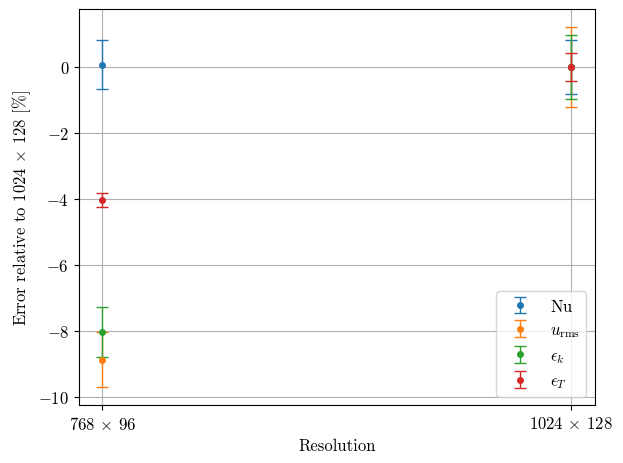

In [30]:
fig, ax = plt.subplots()

for name, var in metrics.items():
    mean_highest, delta_highest = stats.mean_and_uncertainty(
        var[HIGHEST], 't', AVG_TIME,
    )
    means = []
    deltas = []
    for res in RUNS:
        mean, delta = stats.mean_and_uncertainty(var[res], 't', AVG_TIME)
        means.append((mean/mean_highest - 1)*100)
        deltas.append(delta/mean_highest*100)

    ax.errorbar(
        [f'{res[0]} $\\times$ {res[1]}' for res in RUNS], means, yerr=deltas,
        label=name, capsize=4, elinewidth=1, marker='.', linestyle='',
        capthick=1, markersize=8,
    )

# ax.plot([HIGHEST[0]], [0], 'k^', markersize=10, label='``truth"')

ax.legend()
ax.grid()
ax.set(
    xlabel='Resolution',
    ylabel=f'Error relative to {HIGHEST[0]} $\\times$ {HIGHEST[1]} [%]',
)
fig.tight_layout()


In [31]:
client.close()
